<a href="https://colab.research.google.com/github/laurenz-coac/mless/blob/main/homework2/5_LSTM_ozone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

context_window = 336
prediction_horizon = 96
variable_column = ["temp", "o3"] # define the variables wanted for training

In [7]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

# Preparing the Data

When loading the data, we want to make sure that we have both temperature and ozone variables in the input data (X), but define ozone to be predicted (y).

The data was prepared by downloading the multi-variate timeseries, scaling and normalizing, followed by sequencing into the desired time-windows for multi-step prediction.

In [9]:
from re import X
import pickle

# Load the prepared multi-variable data
with open("X_train.pkl", "rb") as f:
    X_train_full = pickle.load(f)

with open("X_test.pkl", "rb") as f:
    X_test_full = pickle.load(f)

with open("y_train.pkl", "rb") as f:
    y_train_full = pickle.load(f)

with open("y_test.pkl", "rb") as f:
    y_test_full = pickle.load(f)

print(f"X_train_full shape: {X_train_full.shape}, y_train_full shape: {y_train_full.shape}")
print(f"X_test_full shape: {X_test_full.shape}, y_test_full shape: {y_test_full.shape}")

## Else if using local files:
dataframe = pd.read_csv("normalized_data.csv")
scaler_stats = {col: {'mean': dataframe[col].mean(), 'std': dataframe[col].std()} for col in variable_column}


# the station code is the first variable column, hence select only the last two
X_train = X_train_full[:,:,1:].copy()
X_test = X_test_full[:,:,1:].copy()

# for the label, we only want the ozone data, which is the second column
y_train = y_train_full[:,:,2].copy()
y_test = y_test_full[:,:,2].copy()

X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# verify the shapes of the data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train_full shape: (21493, 336, 3), y_train_full shape: (21493, 96, 3)
X_test_full shape: (9212, 336, 3), y_test_full shape: (9212, 96, 3)
X_train shape: (21493, 336, 2), y_train shape: (21493, 96)
X_test shape: (9212, 336, 2), y_test shape: (9212, 96)


As we can see from the dataframe shapes, the data is in the desired format. For each train sample, we have 2 input values (i.e. temperature and ozone), while we only predict the ozone measurements.

# Training

First, we define the model and training parameters, nothing to change here yet for our multi-variable case.

In [10]:
# Tunable LSTM parameters
lstm_units = 50
lstm_epochs = 5
lstm_batch_size = 16
lstm_optim = 'adam'
lstm_loss = 'mse'

Adapt the training code to not train a new model for each variable, but instead train a single model taking multiple variables as input. The relevant code-change here is that we initialize the model with a different input shape, since we now have two input variables.

Since we are working in tensorflow, noting else needs to be changed.

In [11]:
checkpoint_dir = "./checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, f"lstm_multivar.h5")

## Ignore user warning on keras as the choice for this exercise is to use h5.
print(f"Training new model for variables {variable_column}")

# the only change needed to allow for multiple input variables is to change the input shape of the LSTM layer
# to match the number of variables in the input data
lstm_model = Sequential([
    LSTM(lstm_units, return_sequences=True, input_shape=(context_window, len(variable_column))), # change to allow mulitple input variables
    LSTM(lstm_units, return_sequences=False),
    Dense(prediction_horizon)
])

lstm_model.compile(optimizer="adam", loss="mse")

checkpoint_callback = ModelCheckpoint(
    checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
)

training = lstm_model.fit(
    X_train,
    y_train,
    epochs=lstm_epochs, batch_size=lstm_batch_size,
    validation_split=0.2, verbose=1,
    callbacks=[checkpoint_callback]
)

training_history = training.history

Training new model for variables ['temp', 'o3']
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1074/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7437
Epoch 1: val_loss improved from inf to 0.58401, saving model to ./checkpoint/lstm_multivar.h5


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - loss: 0.7436 - val_loss: 0.5840
Epoch 2/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5884
Epoch 2: val_loss improved from 0.58401 to 0.57548, saving model to ./checkpoint/lstm_multivar.h5


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - loss: 0.5884 - val_loss: 0.5755
Epoch 3/5
1073/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5587
Epoch 3: val_loss did not improve from 0.57548
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - loss: 0.5587 - val_loss: 0.5851
Epoch 4/5
1074/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5249
Epoch 4: val_loss did not improve from 0.57548
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.5249 - val_loss: 0.5898
Epoch 5/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5070
Epoch 5: val_loss did not improve from 0.57548
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.5070 - val_loss: 0.5871


# Evaluation

We also need to adapt the evaluation code to take into account our multi-variable setup:

In [12]:
X_test.shape, y_test.shape

((9212, 336, 2), (9212, 96))

In [13]:
lstm_predictions = np.zeros_like(y_test)
y_test_actual = np.zeros_like(y_test)

print(f"Predicting for o3...")
# X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0] # we do not need this since only a single station was included in the training data
# why even only predict a single sample in the first place ?

lstm_pred = lstm_model.predict(X_test)

Predicting for o3...
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [14]:
lstm_pred.shape

(9212, 96)

In [15]:
# Evaluate the model for this variable
_ = evaluate_model(y_test, lstm_pred)

RMSE: 0.7292


Plot to verify the results:

In [16]:
X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
context=X_test_full[X_first_idx, :, 2] # for comparability, stick with given code, even though not necessary
# First sample of DENW094 station to compare with PatchTST

actual_future = y_test[X_first_idx, :]
predicted_future = lstm_pred[X_first_idx, :] #actual and pred denormalized in prev cell

In [17]:
# Inverse scale the normalized data

# Inverse scale
context = context * scaler_stats[variable_column[1]]['std'] + scaler_stats[variable_column[1]]['mean']
actual_future = actual_future * scaler_stats[variable_column[1]]['std'] + scaler_stats[variable_column[1]]['mean']
predicted_future = predicted_future * scaler_stats[variable_column[1]]['std'] + scaler_stats[variable_column[1]]['mean']

In [18]:
actual_future.shape, predicted_future.shape

((96,), (96,))

In [21]:
# save whole timeseries

ozone_timeseries = np.concatenate((context, actual_future), axis=0)
plt.figure(figsize=(12, 10))

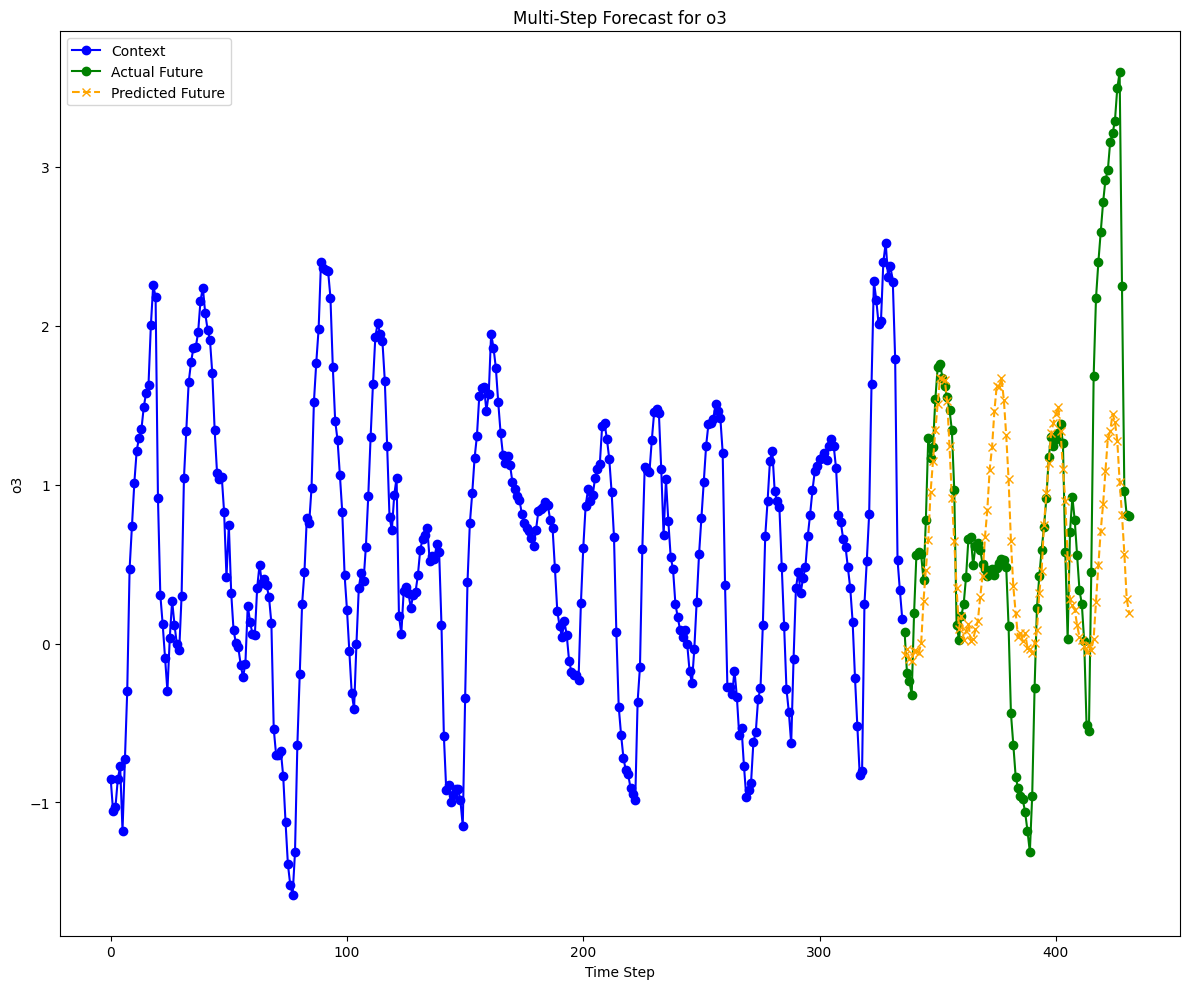

In [19]:
plt.figure(figsize=(12, 10))

# Plot context
plt.plot(range(context_window), context, label="Context", color="blue", marker="o")

# Plot actual future
plt.plot(
    range(context_window, context_window + prediction_horizon),
    actual_future,
    label="Actual Future",
    color="green",
    marker="o"
)

# Plot predicted future
plt.plot(
    range(context_window, context_window + prediction_horizon),
    predicted_future,
    label="Predicted Future",
    color="orange",
    linestyle="--",
    marker="x"
)

plt.title(f"Multi-Step Forecast for o3")
plt.xlabel("Time Step")
plt.ylabel("o3")
plt.legend()

plt.tight_layout()
plt.show()


The above plot shows the prediciton for the ozone measurement given temperature and ozone data. On the shown sample, the prediction does not seem to capture the trends in the ground-truth. While the model seems to have learned the phase of the time-series, the magnitude of each phase was not correctly predicted.

Then save the results for our custom plotting function.

In [20]:
#write forecast values to csv
forecast_df = pd.DataFrame({
    'timepoints': range(context_window, context_window + prediction_horizon),
    'forecast': predicted_future
})

forecast_df.to_csv(f'LSTM_multivar_forecast.csv', index=False)